<a href="https://colab.research.google.com/github/AkibManer2/NST2/blob/main/Colab_Neural_Style_Transfers_ipynb_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
import time
import imageio
import numpy as np
from PIL import Image
import tensorflow as tf
from matplotlib import pyplot as plt
from scipy.optimize import fmin_l_bfgs_b
from tensorflow.keras import backend as K
from tensorflow.keras.applications import vgg19
from tensorflow.keras.preprocessing.image import load_img, img_to_array

tf.compat.v1.disable_eager_execution()

%matplotlib inline

starrynight
nptel_lect.
starrynight_onto_nptel_lect.


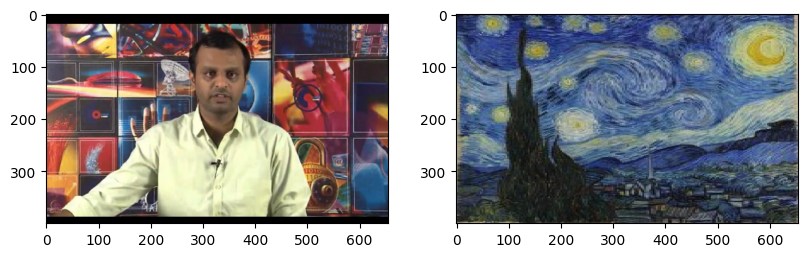

In [14]:
# This is the path to the image you want to transform.
#target_image_path = '/content/drive/MyDrive/Neural Style Transfers/images/venom.jpg'

target_image_path= '/content/drive/MyDrive/Neural Style Transfers/images/New/nptel_lect.jpeg'

# This is the path to the style image.
#style_reference_image_path = '/content/drive/MyDrive/Neural Style Transfers/images/aurora_norway.jpg'

style_reference_image_path='/content/drive/MyDrive/Neural Style Transfers/images/New/starrynight.jpg'


# result_prefix = (style_reference_image_path.split("/content/drive/MyDrive/Neural Style Transfers/images/New/")[1][:-4] +
#                  '_onto_' +
#                  target_image_path.split("/content/drive/MyDrive/Neural Style Transfers/images/New/")[1][:-4])

style_prefix = style_reference_image_path.split("/content/drive/MyDrive/Neural Style Transfers/images/New/")[1][:-4]
target_prefix = target_image_path.split("/content/drive/MyDrive/Neural Style Transfers/images/New/")[1][:-4]
result_prefix = style_prefix + '_onto_' + target_prefix

print(style_prefix)
print(target_prefix)
print(result_prefix)

# Dimensions of the generated picture.
#do consider maintaining the aspect ratio
width, height = load_img(target_image_path).size
img_height = 400
img_width = int(width * img_height / height)

plt.figure(figsize=(15,8))

plt.subplot(131)
plt.imshow(load_img(target_image_path, target_size=(img_height, img_width)))

plt.subplot(132)
plt.imshow(load_img(style_reference_image_path, target_size=(img_height, img_width)))

#from tensorflow.keras.applications import vgg16
#import numpy as np

def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_height, img_width))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

def deprocess_image(x):
    # Remove zero-center by mean pixel and adding standardizing values to B,G,R channels respectively
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8') # limits the value of x between 0 and 255
    return x

###style and content loss calculations

In [15]:


def content_loss(target, final):
    return K.sum(K.square(target - final))  #loss between the content and the generated image

def gram_matrix(x): # as it goes with all lyers consider all the layers
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

def style_loss(style, final_img):
    S = gram_matrix(style)
    F = gram_matrix(final_img)
    channels = 3
    size = img_height * img_width
    return K.sum(K.square(S - F)) / (4. * (channels ** 2) * (size ** 2))


 # as we know the 'content + style = generated' image -> which should not have the more pixels #overlined pixels which increases the pixels which makes blur
 # minimizing the total variation loss so too get unblur image
def total_variation_loss(x):
    a = K.square(x[:, :img_height - 1, :img_width - 1, :] - x[:, 1:, :img_width - 1, :])
    b = K.square(x[:, :img_height - 1, :img_width - 1, :] - x[:, :img_height - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

## Load vgg16 model

In [16]:
#from tensorflow.keras import backend as K


# load reference image and style image
target_image = K.constant(preprocess_image(target_image_path))
style_reference_image = K.constant(preprocess_image(style_reference_image_path))

# This placeholder will contain our final generated image
final_image = K.placeholder((1, img_height, img_width, 3))

# We combine the 3 images into a single batch
input_tensor = K.concatenate([target_image,
                              style_reference_image,
                              final_image], axis=0)

# We build the VGG16 network with our batch of 3 images as input.
# The model will be loaded with pre-trained ImageNet weights.
model = vgg19.VGG19(input_tensor=input_tensor,
                    weights='imagenet',
                    include_top=False)

print('Model loaded.')

Model loaded.


## Computing losses

In [17]:
# creatin a dictionary containing layer_name:layer_output
for layer in model.layers:
  print(layer.name)

outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# Name of layer used for content loss
content_layer = 'block5_conv2'

# Name of layers used for style loss
style_layers = ['block1_conv1',
                'block1_conv2',
                'block2_conv1',
                'block2_conv2',
                'block3_conv1',
                'block3_conv2',
                'block3_conv3',
                'block3_conv4',
                'block4_conv1',
                'block4_conv2',
                'block4_conv3',
                'block4_conv4',
                'block5_conv1']

# Weights in the weighted average of the loss components
total_variation_weight = 1e-6 #(randomly taken)
style_weight = 1e-6         #(randomly taken)
content_weight = 2.5e-8       #(randomly taken)

# Define the loss by adding all components to a `loss` variable
loss = K.variable(0.)
layer_features = outputs_dict[content_layer]
target_image_features = layer_features[0, :, :, :] #as we concatenated them above and here 1 will be style fetures
combination_features = layer_features[2, :, :, :]
loss = loss + content_weight * content_loss(target_image_features,combination_features)# adding content loss

for layer_name in style_layers:

    layer_features = outputs_dict[layer_name]

    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]

    sl = style_loss(style_reference_features, combination_features)
    loss += sl * (style_weight / len(style_layers))      #adding style loss

loss += total_variation_weight * total_variation_loss(final_image)



input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


Finally, we set up the gradient descent process. In the original Gatys et al. paper, optimization is performed using the L-BFGS algorithm, so that is also what we will use here. This is a key difference from the Deep Dream example in the previous section. The L-BFGS algorithms cornes packaged with SciPy. However, there are two slight limitations with the SciPy implementation:


*   It requires to be passed the value of the loss function and the value of the gradients as two separate functions.
*   It can only be applied to flat vectors, whereas we have a 3D image array.


It would be very inefficient for us to compute the value of the loss function and the value of gradients independently, since it would lead to a lot of redundant computation between the two. We would be almost twice slower than we could be by computing them jointly. To by-pass this, we set up a Python class named Evaluator that will compute both loss value and gradients value at once, will return the loss value when called the first time, and will cache the gradients for the next call.

In [18]:
# Get the gradient of the loss wrt the final image means how is loss changing wrt final image
grads = K.gradients(loss, final_image)[0]

# Function to fetch the values of the current loss and the current gradients
fetch_loss_and_grads = K.function([final_image], [loss, grads])


class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        x = x.reshape((1, img_height, img_width, 3))
        outs = fetch_loss_and_grads([x])
        loss_value = outs[0]
        grad_values = outs[1].flatten().astype('float64')
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

In [ ]:
#import time
#from scipy.optimize import fmin_l_bfgs_b


# After 10 iterations little change occurs
iterations = 10

# Run scipy-based optimization (L-BFGS) over the pixels of the generated image so as to minimize the neural style loss.
# This is our initial state: the target image.
# Note that `scipy.optimize.fmin_l_bfgs_b` can only process flat vectors.
x = preprocess_image(target_image_path)
x = x.flatten()

# fmin_l_bfgs_b(func,x) minimizes a function func using the L-BFGS-B algorithm where
# x is the initial guess
# fprime is gradient of the function
# maxfun is Maximum number of function evaluations.

# returns x which is Estimated position of the minimum.
# minval -> Value of func at the minimum.

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    estiated_min, func_val_at_min, info = fmin_l_bfgs_b(evaluator.loss, x,fprime=evaluator.grads, maxfun=600)
    print('Current loss value:', func_val_at_min)
    #print('estmated loss value:', estiated_min)
    #print('info value:', info)

    # Save current generated image
    img = estiated_min.copy().reshape((img_height, img_width, 3))
    img = deprocess_image(img)
    fname = "/content/drive/MyDrive/Neural Style Transfers/outputs/" + result_prefix + '_at_iteration_%d.png' % i
    imageio.imwrite(fname, img)
    end_time = time.time()
    print('Image saved as', fname)
    print('Iteration %d completed in %ds' % (i, end_time - start_time))
    print('\n')

Start of iteration 0


In [ ]:
#from matplotlib import pyplot as plt


plt.figure(figsize=(15,8))

# Content image
plt.subplot(131)
plt.title('Content Image')
plt.imshow(load_img(target_image_path, target_size=(img_height, img_width)))

# Style image
plt.subplot(132)
plt.title('Style Image')
plt.imshow(load_img(style_reference_image_path, target_size=(img_height, img_width)))

# Generate image
plt.subplot(133)
plt.title('Generated Image')
plt.imshow(img)

